# Installation der nötigen Pakete

In [5]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Import der definierten Funktionen

In [6]:
import sys
from pathlib import Path

# Füge src/ zum Python Path hinzu
sys.path.append('..')

# Standard Imports
import numpy as np
import supervision as sv
from PIL import Image

# Projekt-spezifische Imports
from src.config import *
from src.models.modelManager import ModelManager
from src.visualization.visualize import visualize_detections, load_image_from_url

print("✓ Alle Imports erfolgreich")

✓ Alle Imports erfolgreich


# Herunterladen des Modells
- Der Download läuft über die Roboflow API
- API-Key benötigt
- nach dem ersten Aufruf sollte das Modell im Cache sein (und der Aufruf schneller gehen)

In [7]:
# ModelManager initialisieren
model_manager = ModelManager()

# Modell laden (automatisches Caching!)
print("⬇ Lade Modell...")
model = model_manager.load_model()

print(f"  Modell-ID: {MODEL_ID}")

⬇ Lade Modell...
⬇ Lade Modell: football-ball-detection-rejhg/4
  (Verwendet Cache falls bereits heruntergeladen)


Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
Specified provider 'OpenVINOExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
Specified provider 'CoreMLExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'


✓ Modell geladen
  Modell-ID: football-ball-detection-rejhg/4


### Test auf Beispielbild

Modell auf einem Beispielbild testen: Bild von Roboflow

In [8]:
# Beispielbild laden
image_url = "https://source.roboflow.com/GGqN5h3Ag5Msh1nOv8tjZvWDZpv1/o85GBBNAkzLmXE95JZdY/original.jpg"
image = load_image_from_url(image_url)

# Inference durchführen
results = model_manager.infer(image)
print(results)

#Ergebnisse anzeigen
for i, pred in enumerate(results.predictions):
    print(f"  #{i+1}: {pred.class_name} (Konfidenz: {pred.confidence:.2f})")


visualization=None inference_id=None frame_id=None time=None image=InferenceResponseImage(width=1920, height=1080) predictions=[ObjectDetectionPrediction(x=1500.5, y=559.5, width=17.0, height=17.0, confidence=0.8740402460098267, class_name='ball', class_confidence=None, class_id=0, tracker_id=None, detection_id='77804708-f863-45e4-bbda-7edbdfa299eb', parent_id=None)]
  #1: ball (Konfidenz: 0.87)


Visualisierung des Beispiels

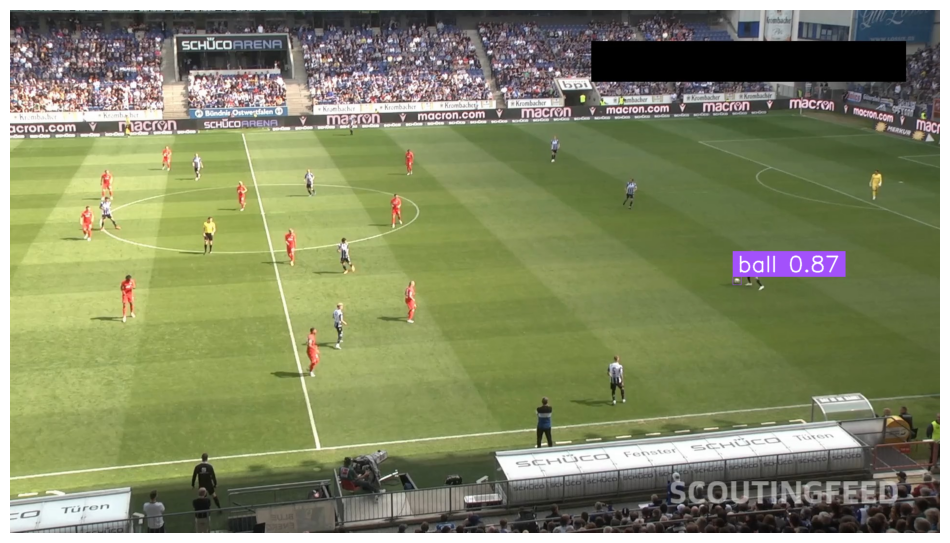

In [9]:
# Visualisierung erstellen
annotated_image = visualize_detections(
    image, 
    results,
    show_confidence=True,
    text_scale=1.5,
    smart_position=True
)

# Anzeigen
sv.plot_image(annotated_image)

# Datenset herunterladen und Testen

Herunterladen des Datensetz über Roboflow Inference.
- für lokale Analysen
- die Daten werden nicht in GIT getrackt

In [10]:
import roboflow

# Roboflow Setup
rf = roboflow.Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace().project("football-ball-detection-rejhg")
version = project.version(4)

# Dataset herunterladen (YOLO Format)
dataset = version.download(
    "yolov8",
    location=str(DATA_DIR)
)

print(f"✓ Dataset gespeichert in: {DATA_DIR}")
print(f"  Training Bilder: {len(list((DATASET_PATH / 'train' / 'images').glob('*.jpg')))}")
print(f"  Validation Bilder: {len(list((DATASET_PATH / 'valid' / 'images').glob('*.jpg')))}")
print(f"  Test Bilder: {len(list((DATASET_PATH / 'test' / 'images').glob('*.jpg')))}")

loading Roboflow workspace...
loading Roboflow project...
✓ Dataset gespeichert in: c:\Users\HP\OneDrive - Duale Hochschule Baden-Württemberg Stuttgart\StudiumGoodNotes\XAI\Computer-Vision_Soccer\notebooks\..\data
  Training Bilder: 3956
  Validation Bilder: 492
  Test Bilder: 500


Test der Heruntergeladenen Daten

📷 Teste mit lokalem Bild: 08fd33_0_mp4-0022_jpg.rf.cb075d7ff9cee66bfc7f0139bc7ca9b2.jpg
Bild geöffnet: Format=JPEG, Modus=RGB, Größe=(640, 640)


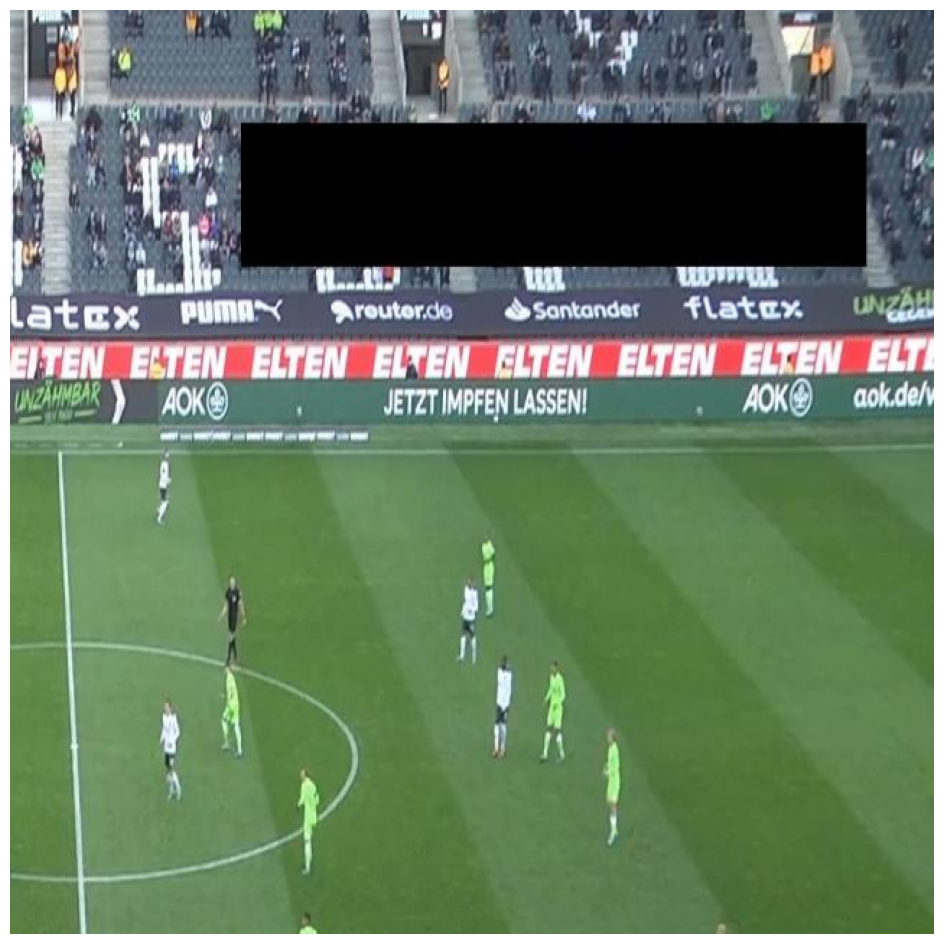

✓ 0 Detection(s) auf lokalem Bild


In [11]:
import random

if DATASET_PATH.exists():
    # Wähle ein zufälliges Validierungsbild
    valid_images = list((DATASET_PATH / "valid" / "images").glob("*.jpg"))
    
    if not valid_images:
        print("⚠️ Keine Bilder im Validierungs-Ordner gefunden")

    random_number = random.randint(0, len(valid_images)-1)

    if valid_images:
        test_image_path = valid_images[random_number]
        print(f"📷 Teste mit lokalem Bild: {test_image_path.name}")
        
        try:
            # Lade Bild
            if not Path(test_image_path).exists():
                raise FileNotFoundError(f"Datei existiert nicht: {test_image_path}")

            try:
                img = Image.open(test_image_path)
                print(f"Bild geöffnet: Format={img.format}, Modus={img.mode}, Größe={img.size}")
            except Exception as e:
                raise RuntimeError(f"Bild konnte nicht geöffnet werden: {e}")

            
            # Inference
            local_results = model_manager.infer(img)

            # Zeige Details der Detections
            if len(local_results.predictions) > 0:
                for i, pred in enumerate(local_results.predictions):
                    print(f"  #{i+1}: {pred.class_name} (Konfidenz: {pred.confidence:.2f})")
            
            # Visualisierung
            local_annotated = visualize_detections(img, local_results)
            sv.plot_image(local_annotated)
            
            print(f"✓ {len(local_results.predictions)} Detection(s) auf lokalem Bild")
        except FileNotFoundError as e:
            print(f"❌ Datei-Fehler: {e}")
        except Exception as e:
            print(f"❌ Unerwarteter Fehler: {e}")
            print(f"   Fehlertyp: {type(e).__name__}")
            import traceback
            traceback.print_exc()
    else:
        print("⚠️ Bild nicht im Dataset gefunden")
else:
    print("ℹ️ Dataset nicht verfügbar")


Alternative Darstellung

['ball 0.82']


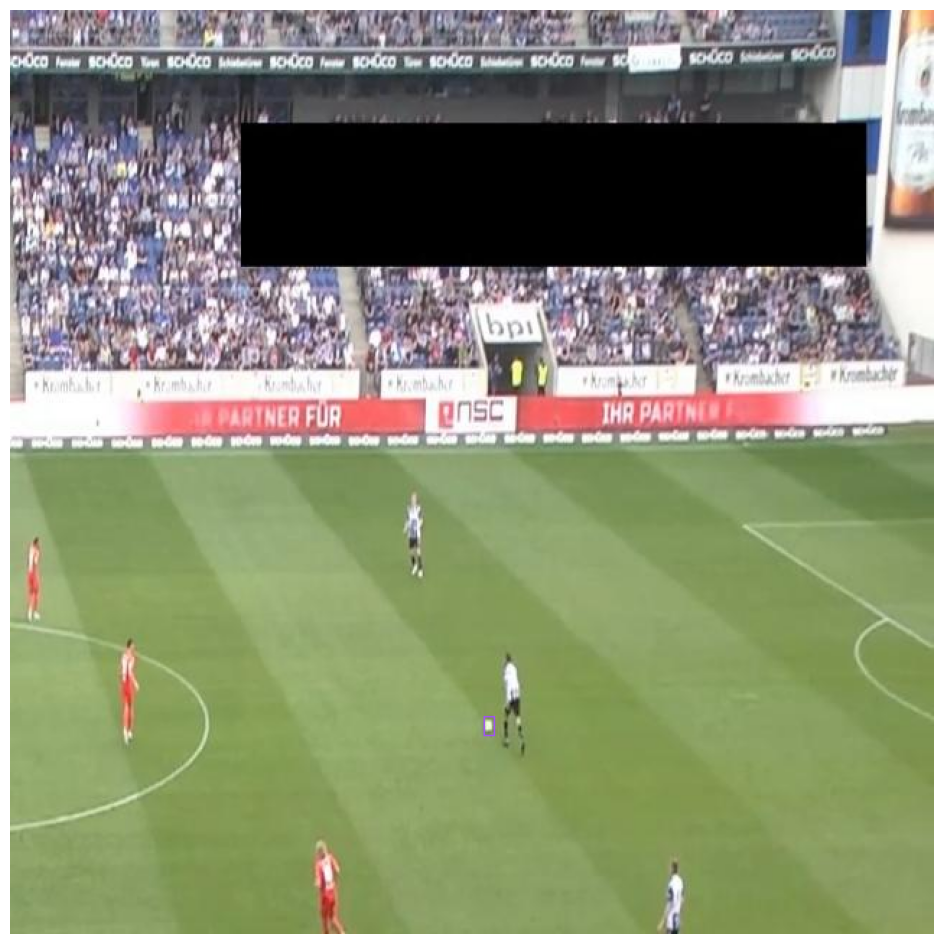

In [12]:
test_image_path = valid_images[486]
image = Image.open(test_image_path)
# Inference
results = model_manager.infer(image)


annotated_image, detection_info = visualize_detections(
    image,
    results,
    labels_on_image=False
)

print(detection_info)
sv.plot_image(annotated_image)